In [1]:
from pathlib import Path

import torch.utils.data
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay

from extended_torch import one_hot_decode
from extended_torch.datasets import CIFAR10, CIFAR10Images
from extended_torch.monitors import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)
from extended_torch.losses import CrossEntropy
from extended_torch.metrics import Accuracy
from extended_torch.models import Model

In [2]:
CHECKPOINT_DIR = Path("checkpoint")
MODEL_PATH = CHECKPOINT_DIR / "model.pth"
OPTIMIZER_PATH = CHECKPOINT_DIR / "optimizer.pth"
DATA_DIR = Path("data")

In [3]:
N_CLASSES = 10
BATCH_SIZE = 8
LEARNING_RATE = 1e-3
N_EPOCHS = 100

In [4]:
train_set = CIFAR10(DATA_DIR, train=True)
valid_set = CIFAR10(DATA_DIR, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
image, label = train_set[0]

In [6]:
image.shape, label.shape

(torch.Size([3, 32, 32]), torch.Size([10]))

In [7]:
train_loader = torch.utils.data.DataLoader(train_set, BATCH_SIZE)
valid_loader = torch.utils.data.DataLoader(valid_set, BATCH_SIZE)

In [8]:
input_batch, target_batch = next(iter(train_loader))

In [9]:
input_batch.shape, target_batch.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32, 10]))

In [10]:
net = torchvision.models.resnet152(num_classes=N_CLASSES)

In [11]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
with torch.no_grad():
    print(net(torch.randn(32, 3, 32, 32)).shape)

torch.Size([32, 10])


In [13]:
loss = CrossEntropy()
trainable_params = [
    param for param in net.parameters() if param.requires_grad
]
optimizer = torch.optim.Adam(trainable_params, LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=0
)
metrics = [Accuracy()]
monitors = [
    EarlyStopping(loss, patience=2),
    ModelCheckpoint(loss, MODEL_PATH, OPTIMIZER_PATH),
    ReduceLROnPlateau(scheduler, loss),
]

In [14]:
model = Model(net, loss, optimizer, metrics, monitors)

In [15]:
model.train(train_loader, valid_loader, N_EPOCHS)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

In [16]:
model.net.load_state_dict(torch.load(MODEL_PATH))
model.optimizer.load_state_dict(torch.load(OPTIMIZER_PATH))

In [17]:
model.test(valid_loader)

  0%|          | 0/313 [00:00<?, ?it/s]

In [18]:
image_set = CIFAR10Images(DATA_DIR, train=False)
image_loader = torch.utils.data.DataLoader(image_set, BATCH_SIZE)

Files already downloaded and verified


In [19]:
labels = torch.cat([target_batch for _, target_batch in valid_loader])
predictions = model.predict(image_loader)

In [20]:
labels.shape, predictions.shape

(torch.Size([10000, 10]), torch.Size([10000, 10]))

In [21]:
decoded_labels = one_hot_decode(labels).to("cpu")
decoded_predictions = one_hot_decode(predictions).to("cpu")

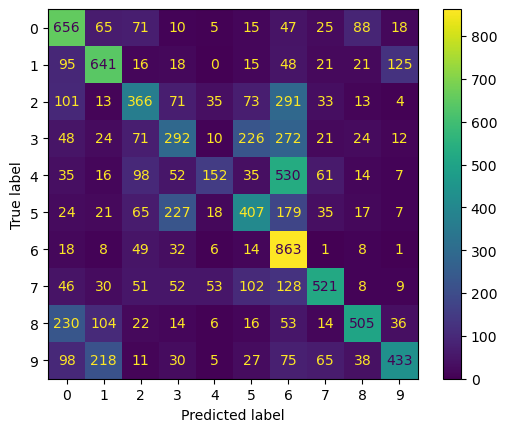

In [22]:
ConfusionMatrixDisplay.from_predictions(
    decoded_labels, decoded_predictions
)